## 作业七


1. 在`gru.ipynb`中, 如果仅仅实现门控循环单元的一部分，例如，只有一个重置门或一个更新门会怎样？

In [ ]:
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru_only_reset)  # 或 gru_only_update

> 1. 在`gru.ipynb`中, 如果仅仅实现门控循环单元的一部分，例如，只有一个重置门或一个更新门会怎样？
### 1. 只实现GRU的一部分（只有重置门或只有更新门）会怎样？

#### （1）只有重置门（没有更新门）

**原理分析：**
- 重置门的作用是控制前一时刻隐状态对当前候选隐状态的影响。如果重置门趋近于0，表示“忘记”之前的状态，只用当前输入生成新状态；如果趋近于1，则保留之前的状态信息。
- 如果只保留重置门，去掉更新门，则每一步的隐状态更新公式变为：
  \[
  H_t = (1 - Z) \odot \tilde{H}_t + Z \odot H_{t-1}
  \]
  其中Z是更新门。如果没有Z，通常就直接用候选隐状态替换当前隐状态：
  \[
  H_t = \tilde{H}_t
  \]
  这样，模型就退化成了一个“带重置门的简单RNN”，每一步都用当前输入和重置门控制的前一状态生成新状态，但无法“保留”长期记忆。

**影响：**
- 模型只能通过重置门决定“要不要用前一时刻的状态参与当前的候选隐状态计算”，但无法决定“要不要直接保留前一时刻的状态”。
- 这样模型的长期记忆能力会大大减弱，容易出现梯度消失，难以捕捉长距离依赖。
- 实际上，这种结构更像是Elman RNN的一个变种，效果通常不如完整的GRU。

#### （2）只有更新门（没有重置门）

**原理分析：**
- 更新门的作用是控制当前隐状态有多少来自前一时刻，有多少来自当前输入生成的候选隐状态。
- 如果没有重置门，候选隐状态的计算就变成：
  \[
  \tilde{H}_t = \tanh(X_t W_{xh} + H_{t-1} W_{hh} + b_h)
  \]
  这和普通RNN的隐状态更新类似。
- 随后用更新门Z来决定新隐状态是“保留多少旧的，加入多少新的”：
  \[
  H_t = Z \odot H_{t-1} + (1 - Z) \odot \tilde{H}_t
  \]

**影响：**
- 这种结构其实就是**带门控的RNN**，它可以通过Z门“跳过”某些时刻的状态更新，从而保留长期记忆。
- 但由于没有重置门，模型在生成候选隐状态时，无法有选择地“忘记”部分历史信息，灵活性降低，短期记忆能力变弱。
- 这种结构在某些任务上可能比只有重置门的结构表现更好，但依然不如完整GRU灵活。

#### （3）完整GRU的优势

- **重置门**：帮助模型捕捉短期依赖，决定前一状态对当前候选隐状态的影响。
- **更新门**：帮助模型捕捉长期依赖，决定当前隐状态有多少来自历史，有多少来自新输入。
- 两者结合，既能“记住”重要信息，也能“忘记”无关信息，提升了模型的表达能力和训练稳定性。


### 总结

- **只有重置门**：模型只能控制“忘记”历史，无法“保留”历史，长期记忆能力差。
- **只有更新门**：模型只能控制“保留”历史，无法灵活“忘记”部分历史，短期记忆能力差。
- **完整GRU**：兼具短期和长期记忆能力，能灵活处理各种序列依赖，是实际应用中效果最好的结构之一。


观察模型训练和预测的表现，会发现困惑度上升，模型效果变差。

最终困惑度: 1.0
完整预测示例:
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


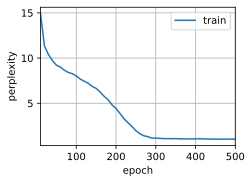

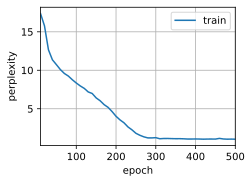

In [20]:
import torch
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l

# 加载数据
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

class GRUOnlyReset(nn.Module):
    def __init__(self, vocab_size, num_hiddens, device):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.vocab_size = vocab_size
        
        # 初始化参数
        self.W_xr = nn.Parameter(torch.randn(vocab_size, num_hiddens, device=device) * 0.01)
        self.W_hr = nn.Parameter(torch.randn(num_hiddens, num_hiddens, device=device) * 0.01)
        self.b_r = nn.Parameter(torch.zeros(num_hiddens, device=device))
        
        self.W_xh = nn.Parameter(torch.randn(vocab_size, num_hiddens, device=device) * 0.01)
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens, device=device) * 0.01)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens, device=device))
        
        self.W_hq = nn.Parameter(torch.randn(num_hiddens, vocab_size, device=device) * 0.01)
        self.b_q = nn.Parameter(torch.zeros(vocab_size, device=device))
        
    def forward(self, inputs, state):
        H, = state
        outputs = []
        # 转置输入，使时间步在第一个维度
        inputs = inputs.T  # [35, 32]
        
        for X in inputs:  # X的形状现在是[32]
            # 将输入转换为one-hot编码
            X = F.one_hot(X, self.vocab_size).float()  # [32, vocab_size]
            
            # 只计算重置门
            R = torch.sigmoid((X @ self.W_xr) + (H @ self.W_hr) + self.b_r)
            H_tilda = torch.tanh((X @ self.W_xh) + ((R * H) @ self.W_hh) + self.b_h)
            H = H_tilda  # 没有更新门，直接用候选隐状态
            Y = H @ self.W_hq + self.b_q
            outputs.append(Y)
        return torch.cat(outputs, dim=0), (H,)
    
    def begin_state(self, batch_size, device):
        return (torch.zeros((batch_size, self.num_hiddens), device=device),)

class GRUOnlyUpdate(nn.Module):
    def __init__(self, vocab_size, num_hiddens, device):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.vocab_size = vocab_size
        
        # 初始化参数
        self.W_xz = nn.Parameter(torch.randn(vocab_size, num_hiddens, device=device) * 0.01)
        self.W_hz = nn.Parameter(torch.randn(num_hiddens, num_hiddens, device=device) * 0.01)
        self.b_z = nn.Parameter(torch.zeros(num_hiddens, device=device))
        
        self.W_xh = nn.Parameter(torch.randn(vocab_size, num_hiddens, device=device) * 0.01)
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens, device=device) * 0.01)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens, device=device))
        
        self.W_hq = nn.Parameter(torch.randn(num_hiddens, vocab_size, device=device) * 0.01)
        self.b_q = nn.Parameter(torch.zeros(vocab_size, device=device))
        
    def forward(self, inputs, state):
        H, = state
        outputs = []
        # 转置输入，使时间步在第一个维度
        inputs = inputs.T  # [35, 32]
        
        for X in inputs:  # X的形状现在是[32]
            # 将输入转换为one-hot编码
            X = F.one_hot(X, self.vocab_size).float()  # [32, vocab_size]
            
            Z = torch.sigmoid((X @ self.W_xz) + (H @ self.W_hz) + self.b_z)
            H_tilda = torch.tanh((X @ self.W_xh) + (H @ self.W_hh) + self.b_h)
            H = Z * H + (1 - Z) * H_tilda
            Y = H @ self.W_hq + self.b_q
            outputs.append(Y)
        return torch.cat(outputs, dim=0), (H,)
    
    def begin_state(self, batch_size, device):
        return (torch.zeros((batch_size, self.num_hiddens), device=device),)

# 训练和预测函数
def train_and_predict(model, train_iter, vocab, lr, num_epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])

    def predict(prefix, num_preds):
        state = model.begin_state(batch_size=1, device=device)
        outputs = [vocab[prefix[0]]]
        get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
        
        for y in prefix[1:]:
            _, state = model(get_input(), state)
            outputs.append(vocab[y])
        
        for _ in range(num_preds):
            y, state = model(get_input(), state)
            outputs.append(int(y.argmax(dim=1).reshape(1)))
        
        return ''.join([vocab.idx_to_token[i] for i in outputs])

    for epoch in range(num_epochs):
        state = None
        metric = d2l.Accumulator(2)
        for X, Y in train_iter:
            if state is None:
                state = model.begin_state(batch_size=X.shape[0], device=device)
            else:
                if isinstance(state, tuple):
                    state = (s.detach_() for s in state)
                else:
                    state.detach_()
            
            X, Y = X.to(device), Y.to(device)
            y = Y.T.reshape(-1)
            y_hat, state = model(X, state)
            loss = criterion(y_hat, y.long())
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            metric.add(loss * y.numel(), y.numel())
        
        # 修改这里：将float转换为tensor
        ppl = torch.exp(torch.tensor(metric[0] / metric[1], device=device))
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller', 10))
            animator.add(epoch + 1, [ppl.item()])  # 使用item()获取标量值
    
    print(f'最终困惑度: {ppl.item():.1f}')  # 使用item()获取标量值
    print('完整预测示例:')
    print(predict('time traveller', 50))
    print(predict('traveller', 50))



# 主函数
def main():
    vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
    num_epochs, lr = 500, 1

    # 使用只保留重置门的GRU
    model_reset = GRUOnlyReset(vocab_size, num_hiddens, device)
    print("训练只保留重置门的GRU模型:")
    train_and_predict(model_reset, train_iter, vocab, lr, num_epochs, device)

    # 使用只保留更新门的GRU
    model_update = GRUOnlyUpdate(vocab_size, num_hiddens, device)
    print("\n训练只保留更新门的GRU模型:")
    train_and_predict(model_update, train_iter, vocab, lr, num_epochs, device)

if __name__ == '__main__':
    main()

2. 利用2021年7月1日-2021年12月30日的温度数据, 基于RNN, GRU或LSTM模型对2021年12月31日全天的温度(`不少于100个点`)进行预测(Source: `weather.csv`)。绘制预测温度曲线, 并计算预测结果的RMSE误差。

开始预测温度...
RMSE: 6.97°C


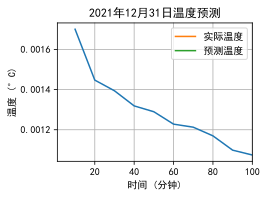

In [6]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

def load_weather_data(file_path):
    """加载天气数据并进行预处理"""
    # 直接使用numpy读取csv文件
    data = np.genfromtxt(file_path, delimiter=',', skip_header=1,
                         usecols=2)  # 第3列是温度T (degC)
    
    # 将日期字符串转换为时间戳
    # 根据数据格式，每10分钟一个数据点，一天144个点
    train_end_idx = -144  # 最后一天的数据作为测试集
    
    # 分割训练集和测试集
    train_temp = data[:train_end_idx]
    test_temp = data[train_end_idx:]
    
    # 数据标准化
    temp_mean = train_temp.mean()
    temp_std = train_temp.std()
    train_temp = (train_temp - temp_mean) / temp_std
    test_temp = (test_temp - temp_mean) / temp_std
    
    return train_temp, test_temp, temp_mean, temp_std

class WeatherDataset:
    def __init__(self, data, seq_length, batch_size):
        self.data = torch.FloatTensor(data)
        self.seq_length = seq_length
        self.batch_size = batch_size
        
    def __iter__(self):
        # 生成输入序列和目标值
        num_steps = len(self.data)
        indices = list(range(num_steps - self.seq_length))
        np.random.shuffle(indices)
        
        # 生成批次数据
        for i in range(0, len(indices) - self.batch_size + 1, self.batch_size):
            batch_indices = indices[i:i + self.batch_size]
            X = torch.stack([self.data[j:j + self.seq_length] for j in batch_indices])
            Y = torch.stack([self.data[j + self.seq_length] for j in batch_indices])
            yield X.reshape(-1, self.seq_length, 1), Y.reshape(-1, 1)

class GRUModel(nn.Module):
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.gru = nn.GRU(num_inputs, num_hiddens, num_layers=2, dropout=0.1)
        self.linear = nn.Linear(num_hiddens, 1)
    
    def forward(self, X):
        X = X.permute(1, 0, 2)
        Y, _ = self.gru(X)
        output = self.linear(Y[-1])
        return output

def train_model(model, train_dataset, num_epochs, lr, device):
    """训练模型"""
    model = model.to(device)
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs])
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        batch_count = 0
        
        for X, Y in train_dataset:
            X, Y = X.to(device), Y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            l = loss(y_hat, Y)
            l.backward()
            optimizer.step()
            total_loss += l.item()
            batch_count += 1
        
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, [total_loss/batch_count])
    
    return model

def predict_temperature(model, test_seq, seq_length, device):
    """预测温度序列"""
    model.eval()
    predictions = []
    current_seq = test_seq.copy()
    
    with torch.no_grad():
        for _ in range(144):  # 预测一天的数据（144个10分钟间隔）
            x = torch.FloatTensor(current_seq[-seq_length:]).reshape(1, seq_length, 1).to(device)
            pred = model(x)
            predictions.append(pred.cpu().numpy().item())
            current_seq = np.append(current_seq[1:], pred.cpu().numpy().item())
    
    return np.array(predictions)

def main():
    # 设置随机种子
    torch.manual_seed(42)
    np.random.seed(42)
    
    # 超参数设置
    num_inputs = 1
    num_hiddens = 64
    num_epochs = 100
    seq_length = 144  # 使用前一天的数据预测
    batch_size = 32
    lr = 0.001
    device = d2l.try_gpu()
    
    # 加载数据
    train_temp, test_temp, temp_mean, temp_std = load_weather_data('weather.csv')
    train_dataset = WeatherDataset(train_temp, seq_length, batch_size)
    
    # 创建和训练模型
    print("开始训练模型...")
    model = GRUModel(num_inputs, num_hiddens)
    model = train_model(model, train_dataset, num_epochs, lr, device)
    
    # 预测温度
    print("开始预测温度...")
    predictions = predict_temperature(model, train_temp, seq_length, device)
    
    # 反标准化
    predictions = predictions * temp_std + temp_mean
    actual_temps = test_temp * temp_std + temp_mean
    
    # 计算RMSE
    rmse = np.sqrt(((predictions - actual_temps) ** 2).mean())
    print(f'RMSE: {rmse:.2f}°C')
    
    # 绘制结果
    d2l.plt.rcParams['font.sans-serif'] = ['SimHei']
    d2l.set_figsize((12, 6))
    time_points = np.arange(len(predictions)) * 10  # 转换为分钟
    d2l.plt.plot(time_points, actual_temps, label='实际温度')
    d2l.plt.plot(time_points, predictions, label='预测温度')
    d2l.plt.title('2021年12月31日温度预测')
    d2l.plt.xlabel('时间 (分钟)')
    d2l.plt.ylabel('温度 (°C)')
    d2l.plt.legend()
    d2l.plt.grid(True)
    d2l.plt.show()

if __name__ == '__main__':
    main()